In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os

### EDA

In [3]:
df = pd.read_csv("train_labels.csv")
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
test_df = pd.DataFrame({'id': os.listdir('test/')})
test_df.head()

,id
0,00006537328c33e284c973d7b39d340809f7271b.tif
1,0000ec92553fda4ce39889f9226ace43cae3364e.tif
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
3,000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
4,000270442cc15af719583a8172c87cd2bd9c7746.tif


In [5]:
df.label = df.label.astype(str)
df.id=df.id + '.tif'
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [6]:
n_train_samples = len(os.listdir('train/'))
n_test_samples = len(os.listdir('test/'))

print(f"Train Size: {n_train_samples}")
print(f"Test Size: {n_test_samples}")

Train Size: 220025
Test Size: 57458


In [7]:
label_counts = df.label.value_counts()
print(label_counts)

label
0    130908
1     89117
Name: count, dtype: int64


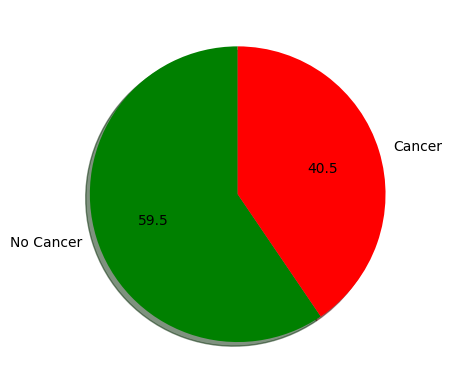

<Figure size 1500x1500 with 0 Axes>

In [8]:
plt.pie(label_counts, labels=['No Cancer', 'Cancer'], startangle=90, autopct='%1.1f', colors=['green', 'red'], shadow=True)
plt.figure(figsize=(15,15))
plt.show()

In [9]:
train_dir = 'train'
test_dir = 'test'

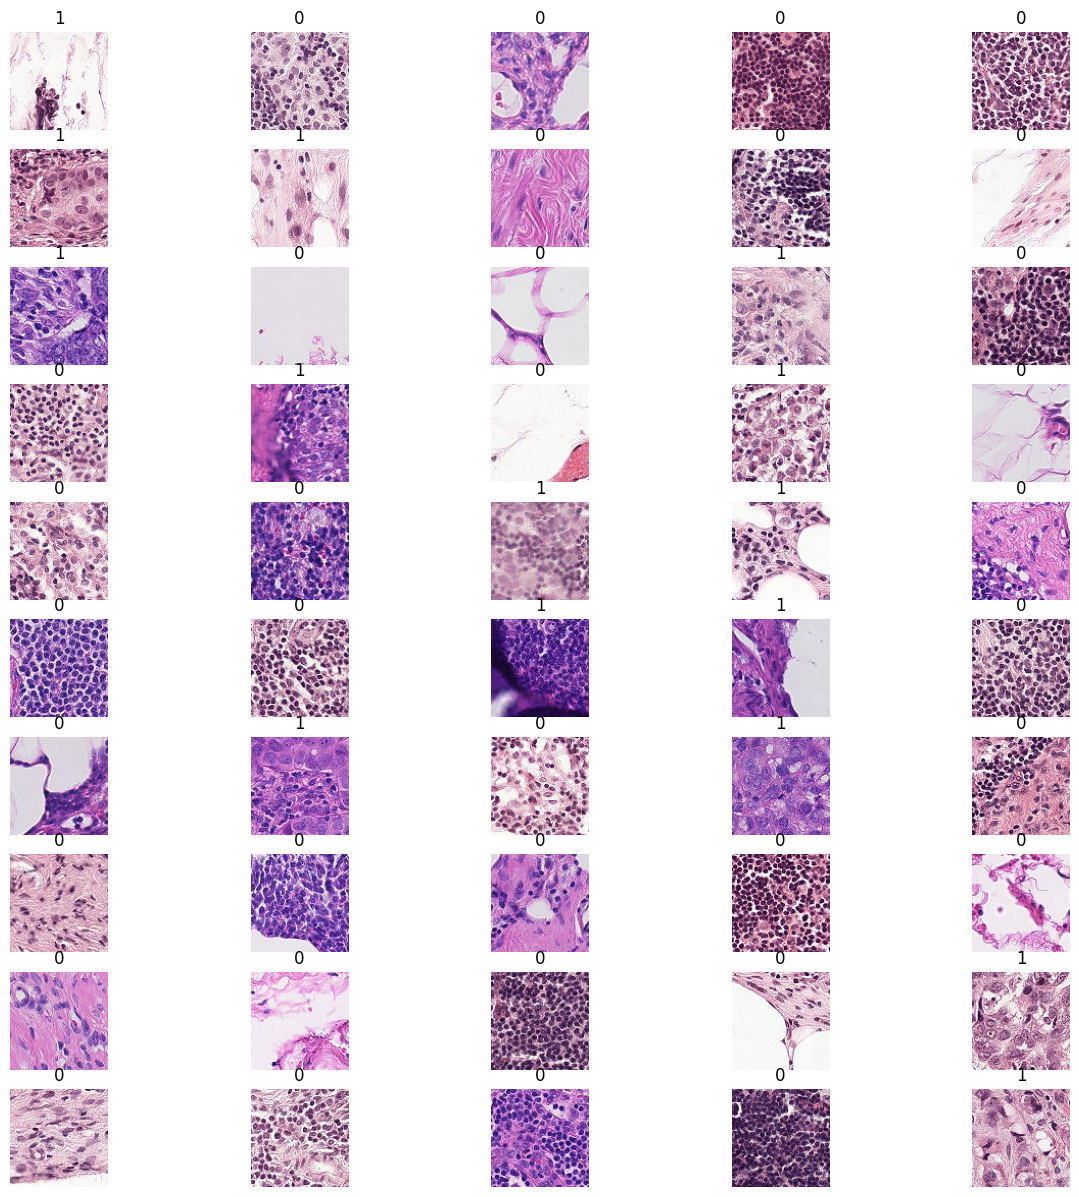

In [10]:
fig = plt.figure(figsize=(15,15))
rows = 10
columns = 5
for i in range(1, rows*columns+1):
    img = plt.imread(train_dir + '/' + df.iloc[i]['id'])# +'.tif')
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.title(df.iloc[i]["label"])
    plt.imshow(img)
plt.show()

Image Shape: (96, 96, 3)
Label: 0


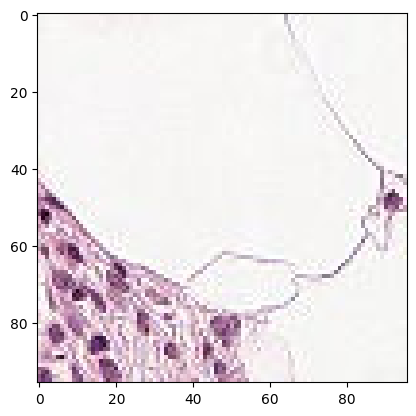

In [11]:
plt.figure()
img = plt.imread(train_dir + '/' + df.iloc[0]['id'])
print("Image Shape:", img.shape)
print("Label:", df.iloc[0]['label'])
plt.imshow(img)
plt.show()

### Preparing Dataset for Keras

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [13]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=90,
        validation_split=.2
    )

test_datagen = ImageDataGenerator(
            rescale=1./255
)

In [14]:
train_generator = train_datagen.flow_from_dataframe(
            dataframe=df,
            directory=train_dir,
            x_col='id',
            y_col='label',
            subset='training',
            target_size=(96,96),
            batch_size=32,
            class_mode='binary',
            shuffle=True,
            seed=42
)

valid_generator = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=train_dir,
        x_col='id',
        y_col='label',
        subset='validation',
        target_size=(96,96),
        batch_size=32,
        shuffle=False,
        class_mode='binary'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [15]:
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    directory='test/',
    x_col='id', 
    y_col=None,
    target_size=(96,96),         
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


### Creating Models

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

#### Model 1

In [48]:
model_1 = Sequential()

In [49]:
model_1.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model_1.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_1.add(Flatten())
model_1.add(Dense(1, activation='sigmoid'))

In [50]:
model_1.build(input_shape=(256, 96, 96, 3))
model_1.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [51]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (256, 94, 94, 16)         448       
                                                                 
 conv2d_10 (Conv2D)          (256, 92, 92, 16)         2320      
                                                                 
 max_pooling2d_4 (MaxPoolin  (256, 46, 46, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (256, 44, 44, 32)         4640      
                                                                 
 conv2d_12 (Conv2D)          (256, 42, 42, 32)         9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (256, 21, 21, 32)         0         
 g2D)                                                 

#### Model 2

In [21]:
model_2 = Sequential()

# First Convolutional Layer
model_2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(96, 96, 3)))

# Second Convolutional Layer
model_2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))

# Max Pooling Layer
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Layer
model_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

# Fourth Convolutional Layer
model_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

# Max Pooling Layer
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten Layer
model_2.add(Flatten())

# Fully Connected Layers
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.5))  # Dropout layer to reduce overfitting

# Output Layer
model_2.add(Dense(1, activation='sigmoid'))


In [22]:
# Compile the model
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Train

In [55]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [56]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [57]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [58]:
# Train the model with the new callback. Add model history?
model_1.fit(train_generator,   
          epochs=10,
          validation_data=valid_generator,
          callbacks=[cp_callback, early_stopping])  # Pass callback to training

Epoch 1/10
5501/5501 [==============================] - ETA: 0s - loss: 0.4115 - accuracy: 0.8166
Epoch 1: saving model to training_1\cp.ckpt
5501/5501 [==============================] - 1078s 196ms/step - loss: 0.4115 - accuracy: 0.8166 - val_loss: 0.3380 - val_accuracy: 0.8569
Epoch 2/10
5501/5501 [==============================] - ETA: 0s - loss: 0.3319 - accuracy: 0.8573
Epoch 2: saving model to training_1\cp.ckpt
5501/5501 [==============================] - 1003s 182ms/step - loss: 0.3319 - accuracy: 0.8573 - val_loss: 0.3147 - val_accuracy: 0.8660
Epoch 3/10
5501/5501 [==============================] - ETA: 0s - loss: 0.3014 - accuracy: 0.8739
Epoch 3: saving model to training_1\cp.ckpt
5501/5501 [==============================] - 1030s 187ms/step - loss: 0.3014 - accuracy: 0.8739 - val_loss: 0.2941 - val_accuracy: 0.8789
Epoch 4/10
5501/5501 [==============================] - ETA: 0s - loss: 0.2841 - accuracy: 0.8834
Epoch 4: saving model to training_1\cp.ckpt
5501/5501 [=======

In [60]:
model_1.save("model_1_trained.keras")

In [62]:
predictions = model_1.predict(test_generator, verbose=1)

57458/57458 [==============================] - 162s 3ms/step


In [63]:
predictions = np.transpose(predictions)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_df['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
submission_df.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0


In [64]:
submission_df.to_csv('submission.csv', index=False)

In [23]:
EPOCHS = 10

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_1.h5', save_best_only=True)

In [25]:
# train the model
history_model_1 = model_1.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
5501/5501 [==============================] - 1124s 204ms/step - loss: 0.4302 - accuracy: 0.8057 - val_loss: 0.3661 - val_accuracy: 0.8425
Epoch 2/10


C:\Users\oshan\Machine Learning Projects\Deep Learning\Computer Vision\Histopathologic Cancer Detection\HCP\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5501/5501 [==============================] - 1061s 193ms/step - loss: 0.3480 - accuracy: 0.8498 - val_loss: 0.3901 - val_accuracy: 0.8397
Epoch 3/10
5501/5501 [==============================] - 1069s 194ms/step - loss: 0.3096 - accuracy: 0.8695 - val_loss: 0.2861 - val_accuracy: 0.8847
Epoch 4/10
5501/5501 [==============================] - 1116s 203ms/step - loss: 0.2918 - accuracy: 0.8796 - val_loss: 0.2855 - val_accuracy: 0.8790
Epoch 5/10
5501/5501 [==============================] - 1116s 203ms/step - loss: 0.2777 - accuracy: 0.8866 - val_loss: 0.2590 - val_accuracy: 0.8954
Epoch 6/10
5501/5501 [==============================] - 1084s 197ms/step - loss: 0.2693 - accuracy: 0.8915 - val_loss: 0.2692 - val_accuracy: 0.8901
Epoch 7/10
5501/5501 [==============================] - 1059s 192ms/step - loss: 0.2639 - accuracy: 0.8937 - val_loss: 0.2681 - val_accuracy: 0.8955
Epoch 8/10
5501/5501 [==============================] - 1082s 197ms/step - loss: 0.2578 - accuracy: 0.8963 - val_loss

In [27]:
training_loss = history_model_1.history['loss']
validation_loss = history_model_1.history['val_loss']
training_accuracy = history_model_1.history['accuracy']
validation_accuracy = history_model_1.history['val_accuracy']

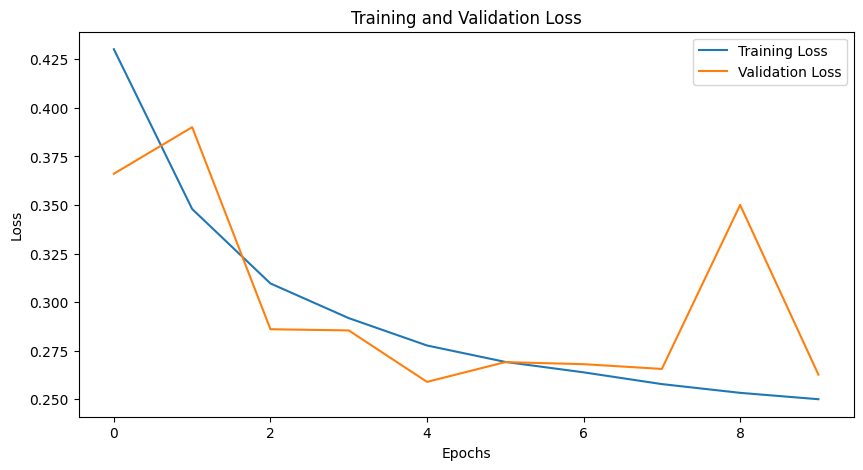

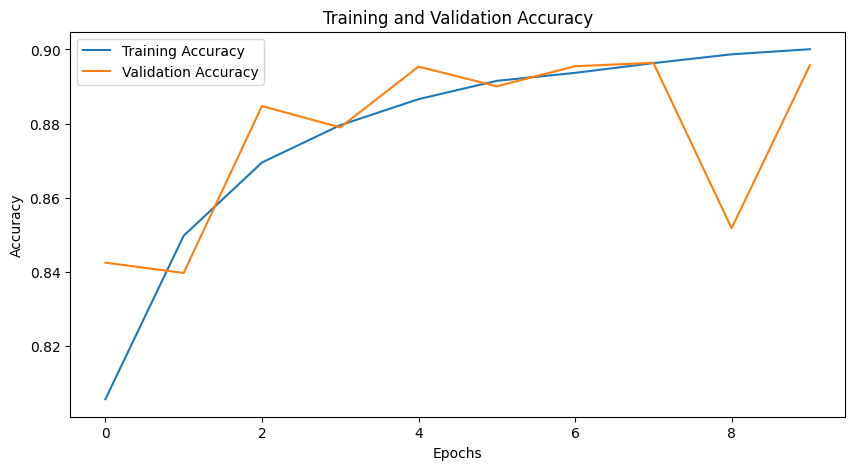

In [28]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()